In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy as cp

In [2]:
%matplotlib inline

#### Read stations data

In [3]:
stations = pd.read_csv('./station_info.csv', skiprows=[1], encoding="ISO-8859-1")
stations = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.geoLaenge, stations.geoBreite))
stations.head(3)

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland,Unnamed: 8,Unnamed: 9,Unnamed: 10,geometry
0,3,19370101,20110331,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen,NaN,NaN,NaN,POINT (6.09410 50.78270)
1,11,19800901,20200930,680,47.9737,8.5205,Donaueschingen,(Landeplatz),Baden-Württemberg,NaN,NaN,POINT (8.52050 47.97370)
2,44,19690101,19951130,44,52.9336,8.2370,Großenkneten,Niedersachsen,NaN,NaN,NaN,POINT (8.23700 52.93360)


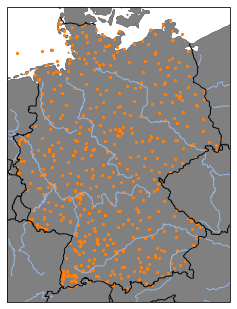

In [4]:
fig, ax = plt.subplots(1,1, figsize=(4,6), subplot_kw=dict(projection=cp.crs.AlbersEqualArea()))
stations.plot(ax=ax, transform=cp.crs.PlateCarree(), c='C1', markersize=5)
ax.coastlines(zorder=-10)
ax.add_feature(cp.feature.LAND, fc='grey')
ax.add_feature(cp.feature.RIVERS)
ax.add_feature(cp.feature.BORDERS)
plt.show()

#### Read windspeed data

In [5]:
winds = pd.read_csv('wind_speed.csv')

Convert windspeed from (`speed`, `direction`) pairs to (`u`, `v`) components

In [6]:
winds['u'] = -1 * winds['F'] * np.sin(winds['D']*np.pi/180)
winds['v'] = -1 * winds['F'] * np.cos(winds['D']*np.pi/180)

In [7]:
winds.MESS_DATUM = pd.to_datetime(winds.MESS_DATUM)
winds = winds.groupby([winds.STATIONS_ID, winds.MESS_DATUM.dt.dayofyear]).agg(lambda x: np.percentile(x, q = 90)).iloc[:,-5:].reset_index()
winds.head()

,STATIONS_ID,MESS_DATUM,QN_3,F,D,u,v
0,90,1,1.0,4.47,250.0,4.135729,2.249927
1,90,2,1.0,9.09,247.0,7.872171,5.219435
2,90,3,1.0,8.71,270.0,8.440000,3.585000
3,90,4,1.0,7.30,280.0,6.321985,3.575000
4,90,5,1.0,9.35,280.0,8.786126,3.197888


In [8]:
merged = stations.merge(winds, left_on='Stations_id', right_on=winds.STATIONS_ID)
merged.shape

(13858, 19)

In [9]:
merged['x'] = merged.geometry.x
merged['y'] = merged.geometry.y
merged.head()

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland,Unnamed: 8,Unnamed: 9,...,geometry,STATIONS_ID,MESS_DATUM,QN_3,F,D,u,v,x,y
0,90,19880219,20220217,305,50.7557,9.2583,Alsfeld,Hessen,NaN,NaN,...,POINT (9.25830 50.75570),90,1,1.0,4.47,250.0,4.135729,2.249927,9.2583,50.7557
1,90,19880219,20220217,305,50.7557,9.2583,Alsfeld,Hessen,NaN,NaN,...,POINT (9.25830 50.75570),90,2,1.0,9.09,247.0,7.872171,5.219435,9.2583,50.7557
2,90,19880219,20220217,305,50.7557,9.2583,Alsfeld,Hessen,NaN,NaN,...,POINT (9.25830 50.75570),90,3,1.0,8.71,270.0,8.440000,3.585000,9.2583,50.7557
3,90,19880219,20220217,305,50.7557,9.2583,Alsfeld,Hessen,NaN,NaN,...,POINT (9.25830 50.75570),90,4,1.0,7.30,280.0,6.321985,3.575000,9.2583,50.7557
4,90,19880219,20220217,305,50.7557,9.2583,Alsfeld,Hessen,NaN,NaN,...,POINT (9.25830 50.75570),90,5,1.0,9.35,280.0,8.786126,3.197888,9.2583,50.7557


In [10]:
from matplotlib import animation
import contextily as cx
from datetime import datetime as dt

%matplotlib notebook

<IPython.core.display.Javascript object>


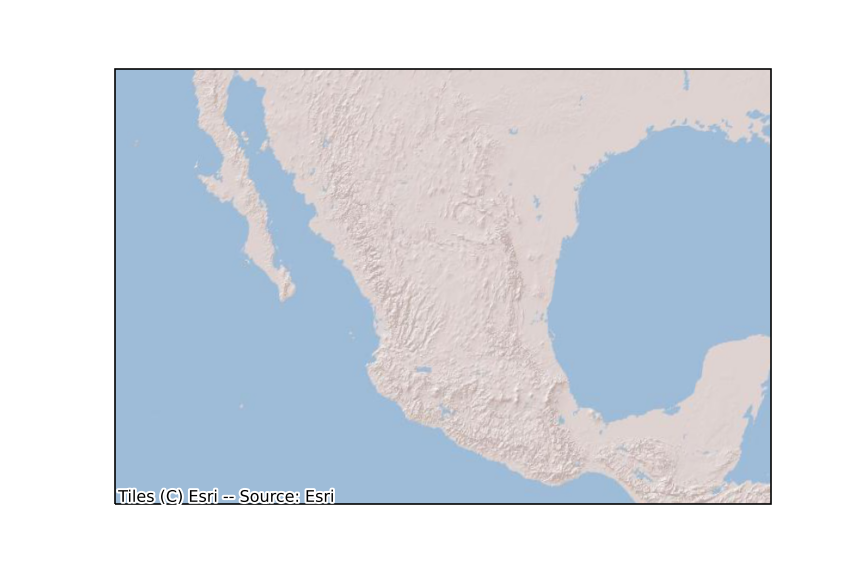

In [13]:
fig, ax = plt.subplots(subplot_kw=dict(projection=cp.crs.Robinson()))
ax.set_extent([-116,-90,15,32], crs=cp.crs.PlateCarree())
cx.add_basemap(ax, source=cx.providers.Esri.WorldShadedRelief, zoom=5, crs=cp.crs.Robinson())

In [16]:
extent = [0,20,46,56]

<IPython.core.display.Javascript object>


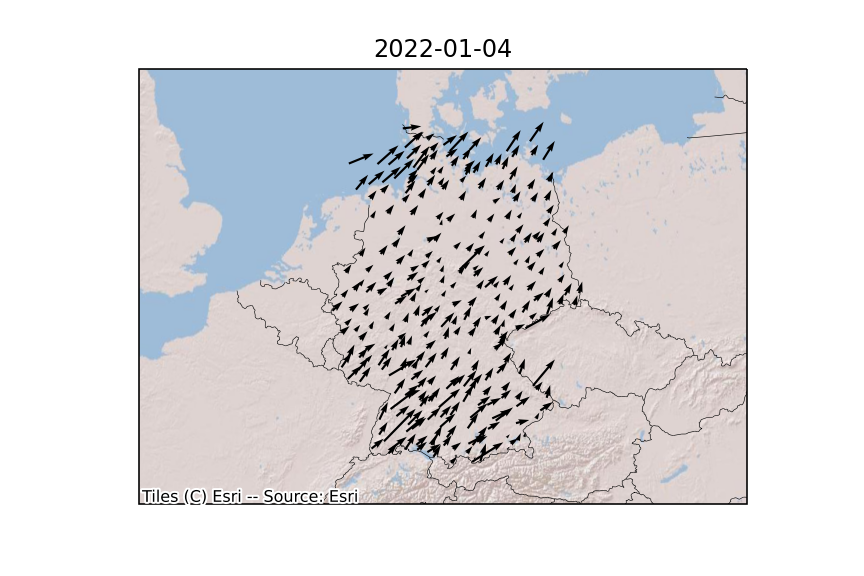

In [20]:
fig, ax = plt.subplots(subplot_kw=dict(projection=cp.crs.Orthographic(central_longitude=10, central_latitude=50)))


quiver = ax.quiver(merged.x.values, merged.y.values, 
          np.zeros(len(merged.y)), np.zeros(len(merged.y)), 
          transform=cp.crs.PlateCarree()
         )

ax.set_extent(extent, crs=cp.crs.PlateCarree())

cx.add_basemap(ax=ax, 
               source=cx.providers.Esri.WorldShadedRelief, 
               zoom=6, 
               crs=cp.crs.Orthographic(central_longitude=10, central_latitude=50))


ax.add_feature(cp.feature.LAND, fc='#EADFDB')
# ax.add_feature(cp.feature.RIVERS, lw=0.5)
ax.add_feature(cp.feature.BORDERS, lw=0.3)
ax.add_feature(cp.feature.OCEAN, fc='#BBDCF1', zorder=-10)
# ax.set_title('')

def animate(i):
    time = list(set(merged.MESS_DATUM.values))[i]
    
    ax.clear()
#     quiver.remove()
    
    df_ = merged[merged.MESS_DATUM==time]
    
    quiver = ax.quiver(df_.x.values, df_.y.values, df_.u, df_.v, 
              zorder=10, scale=300, minlength=1, transform=cp.crs.PlateCarree()).figure
    
    ax.set_extent([0,20,46,56], crs=cp.crs.PlateCarree())
    
    cx.add_basemap(ax=ax, 
               source=cx.providers.Esri.WorldShadedRelief, 
               zoom=6, 
               crs=cp.crs.Orthographic(central_longitude=10, central_latitude=50))
    ax.add_feature(cp.feature.LAND, fc='#EADFDB')
#     ax.add_feature(cp.feature.RIVERS,  lw=0.3)
    ax.add_feature(cp.feature.BORDERS, lw=0.3)
    ax.add_feature(cp.feature.OCEAN, fc='#BBDCF1', zorder=-10)

    ax.set_title('%s'%(dt.strftime(pd.to_timedelta(i, 'D') + pd.to_datetime('2022-01-01'), '%Y-%m-%d')))

anim = animation.FuncAnimation(fig, animate, frames=len(list(set(merged.MESS_DATUM.values))), blit=True, interval=0.5)

In [21]:
# anim.save('windspeed.gif', savefig_kwargs={'facecolor':'white'}, dpi=150)